In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
 pip install -q -U keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.1 MB/s eta 0:00:00


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import keras_tuner as kt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2


In [4]:
#Load data
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/crude-oil-price.csv')
print(df.head())

                        date  price  percentChange  change
0  1983-03-01 00:00:00+00:00  29.27            NaN     NaN
1  1983-04-01 00:00:00+00:00  30.63          4.646    1.36
2  1983-05-01 00:00:00+00:00  30.25         -1.241   -0.38
3  1983-06-01 00:00:00+00:00  31.38          3.736    1.13
4  1983-07-01 00:00:00+00:00  32.00          1.976    0.62


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           506 non-null    object 
 1   price          506 non-null    float64
 2   percentChange  505 non-null    float64
 3   change         505 non-null    float64
dtypes: float64(3), object(1)
memory usage: 15.9+ KB


In [6]:
# Mengubah kolom 'date' menjadi format datetime dan menjadikannya sebagai index DataFrame
df['date'] = pd.to_datetime(df['date'])


In [7]:
#Checking missing value
missing_values = df.isnull().sum()
print(missing_values)

date             0
price            0
percentChange    1
change           1
dtype: int64


In [8]:
#Checking duplicate
duplikat = df.duplicated().sum()
print(duplikat)

0


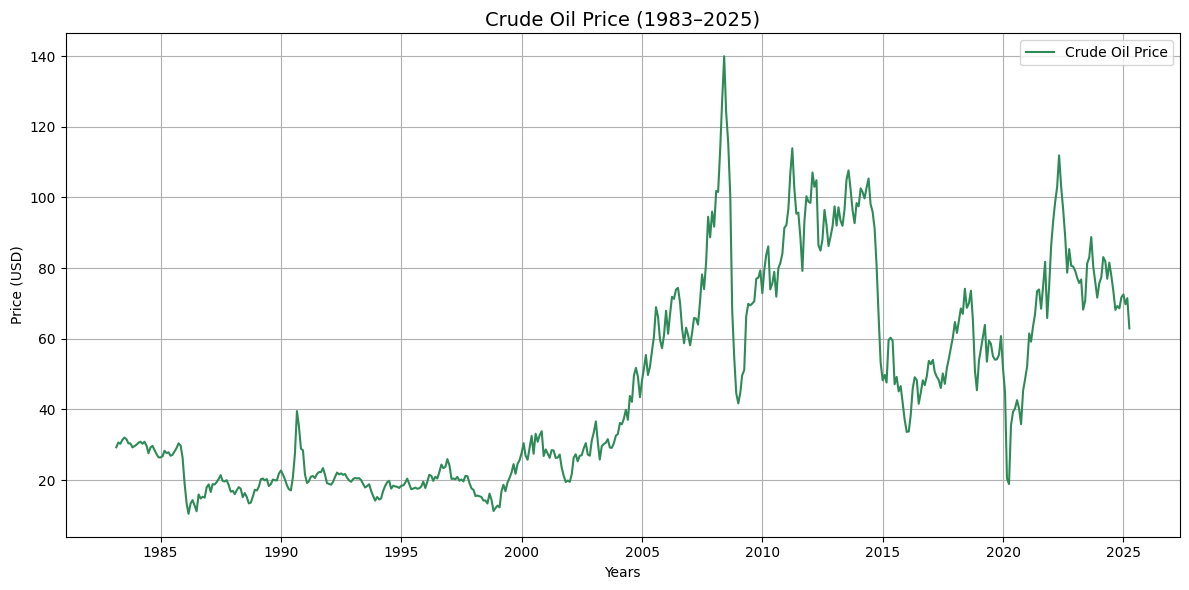

In [9]:
# Visualisasi
plt.figure(figsize=(12,6))
plt.plot(df['date'], df['price'], color='seagreen', label='Crude Oil Price')
plt.title('Crude Oil Price (1983–2025)', fontsize=14)
plt.xlabel('Years')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [10]:
#Normalization
scaler = MinMaxScaler()
df['scaled'] = scaler.fit_transform(df[['price']])
df.head()

,date,price,percentChange,change,scaled
0,1983-03-01 00:00:00+00:00,29.27,NaN,NaN,0.145470
1,1983-04-01 00:00:00+00:00,30.63,4.646,1.36,0.155965
2,1983-05-01 00:00:00+00:00,30.25,-1.241,-0.38,0.153033
3,1983-06-01 00:00:00+00:00,31.38,3.736,1.13,0.161753
4,1983-07-01 00:00:00+00:00,32.00,1.976,0.62,0.166538


In [11]:
#Sequence builder
# Fungsi untuk membentuk urutan data (sequence) untuk pemodelan time series
def create_sequences(data, window_size = 12):
  X, y = [], []
  # Membentuk pasangan input (X) dan target (y) dengan sliding window

  for i in range(window_size, len(data)):
    X.append(data[i-window_size:i]) # urutan input sepanjang window_size
    y.append(data[i])               # nilai target (berikutnya setelah urutan)
  return np.array(X), np.array(y)

# Menentukan ukuran jendela (window) dan membentuk sequence dari data yang sudah diskalakan
window_size = 12
X,y =create_sequences(df['scaled'].values, window_size)

# Mengambil data tanggal mulai dari baris ke-window_size, menghapus informasi zona waktu, dan mereset index
dates = df['date'][window_size:].dt.tz_localize(None).reset_index(drop=True)



**Split Data**

Data dibagi menjadi 3 bagian:
* Train (1983-2018) untuk melatih model dari pola historis
* Val (2019-2021) untuk tuning dan pengecekan kemampuan dalam menghadapi Covid
* Test (2022-2025) untuk evaluasi model pada data terbaru







In [12]:
#Split data
train_end = pd.to_datetime('2018-12-01')
val_end = pd.to_datetime('2021-12-01')

# Membuat index boolean untuk setiap subset data
train_idx = dates <= train_end
val_idx = (dates > train_end) & (dates <= val_end)
test_idx = dates > val_end

# Mengambil subset data berdasarkan index yang telah dibuat
X_train, X_val, X_test = X[train_idx], X[val_idx], X[test_idx]
y_train, y_val, y_test = y[train_idx], y[val_idx], y[test_idx]

# Mengubah dimensi input agar sesuai dengan format input LSTM: (samples, timesteps, features)
X_train = X_train.reshape((-1, window_size, 1))
X_val = X_val.reshape((-1, window_size, 1))
X_test = X_test.reshape((-1, window_size, 1))

In [13]:
#Hypermarameter Tuning
import keras_tuner as kt
def build_model(hp):
    model = Sequential()

    # LSTM Layer pertama dengan Regularisasi dan Dropout
    model.add(LSTM(
        units=hp.Int('units_layer1', min_value=32, max_value=128, step=32),
        input_shape=(window_size, 1),
        kernel_regularizer=l2(hp.Float('l2_reg_layer1', 1e-5, 1e-3, sampling='log')),
        return_sequences=True
    ))
    model.add(Dropout(hp.Float('dropout_rate1', 0.1, 0.5, step=0.1)))

    # LSTM Layer kedua
    model.add(LSTM(
        units=hp.Int('units_layer2', min_value=32, max_value=128, step=32),
        kernel_regularizer=l2(hp.Float('l2_reg_layer2', 1e-5, 1e-3, sampling='log')),
    ))
    model.add(Dropout(hp.Float('dropout_rate2', 0.1, 0.5, step=0.1)))

    model.add(Dense(1))

    # Compile dengan optimizer dan learning rate yang dituning
    model.compile(
        optimizer=Adam(hp.Float('lr', 1e-4, 1e-2, sampling='log')),
        loss='mse'
    )
    return model

# Tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=20,
    executions_per_trial=1,
    directory='my_dir',
    project_name='lstm_tuning'
)

# Mulai tuning
tuner.search(X_train, y_train, validation_data=(X_val, y_val), epochs=50)

Trial 20 Complete [00h 00m 16s]
val_loss: 0.007931647822260857

Best val_loss So Far: 0.005565226078033447
Total elapsed time: 00h 06m 31s


In [14]:
#Mengambil model terbaik
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 12, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 96)             │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 153,057 (597.88 KB)

 Trainable params: 153,057 (597.88 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
#Training ulang

#Callback untuk menghentikan pelatihan saat validasi loss berhenti membaik
early_stop = EarlyStopping(monitor='val_loss',            # Pantau metrik val_loss
                           patience=5,  ## Jika val_loss tidak membaik dalam 5 epoch berturut-turut, hentikan training
                           restore_best_weights=True) # Pulihkan bobot model dari epoch dengan val_loss terbaik


#Melatih model terbaik hasil tuning
history = best_model.fit(
    X_train, y_train,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1                         # Menampilkan progress training
)

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0028 - val_loss: 0.0059
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0030 - val_loss: 0.0056
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0033 - val_loss: 0.0058
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0035 - val_loss: 0.0063
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0034 - val_loss: 0.0064
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0050 - val_loss: 0.0056
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0045 - val_loss: 0.0068
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0041 - val_loss: 0.0054
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0036 - val_loss: 0.0055
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0033 - val_loss: 0.0055
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0037 - val_loss: 0.0060
Epoch 12/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

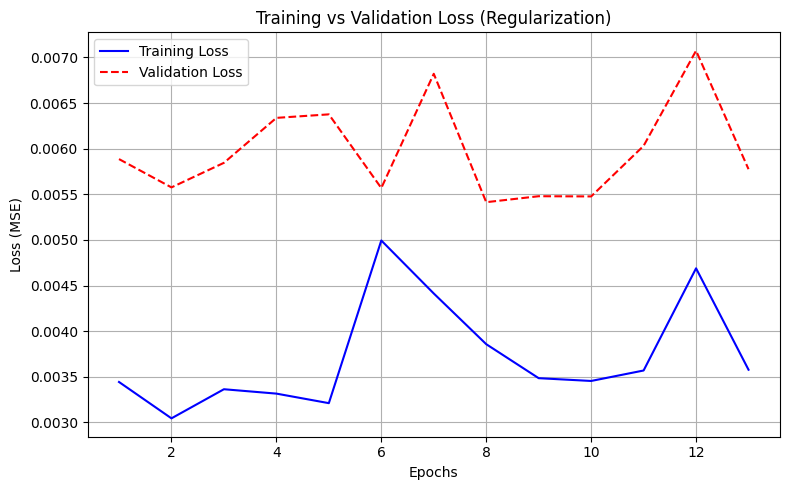

In [23]:
# Mengakses history
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

# Plot
plt.figure(figsize=(8,5))
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r--', label='Validation Loss')
plt.title('Training vs Validation Loss (Regularization)')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("drive/MyDrive/Colab Notebooks/Crude Oil Price LSTM/Crude Oil Price Images/5-Train-Val-Loss-Regularization.png", dpi=300)
plt.show()

In [24]:
#Prediksi
y_train_pred = best_model.predict(X_train)
y_val_pred = best_model.predict(X_val)
y_test_pred = best_model.predict(X_test)

# Inverse transform data aktual dan prediksi
y_train_inv = scaler.inverse_transform(y_train.reshape(-1,1))
y_val_inv = scaler.inverse_transform(y_val.reshape(-1,1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))

y_train_pred_inv = scaler.inverse_transform(y_train_pred)
y_val_pred_inv = scaler.inverse_transform(y_val_pred)
y_test_pred_inv = scaler.inverse_transform(y_test_pred)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [25]:
#Evaluasi Model

rmse = np.sqrt(mean_squared_error(y_test_inv, y_test_pred_inv))
mae = mean_absolute_error(y_test_inv, y_test_pred_inv)

print(f"Test RMSE: {rmse:.2f}")
print(f"Test MAE : {mae:.2f}")


Test RMSE: 6.71
Test MAE : 5.18


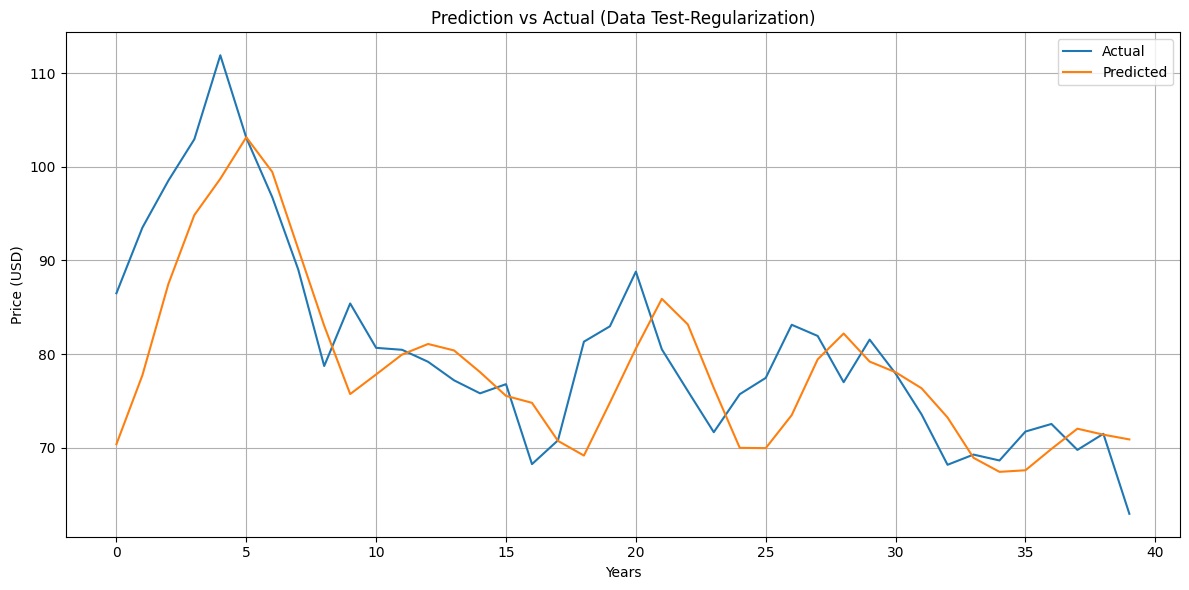

In [26]:
#Evaluasi Test Set
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_test_pred_inv, label='Predicted')
plt.title("Prediction vs Actual (Data Test-Regularization)")
plt.xlabel("Years")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("drive/MyDrive/Colab Notebooks/Crude Oil Price LSTM/Crude Oil Price Images/6-Prediction_vs_Actual_Test-Regularization.png", dpi=300)
plt.show()

In [27]:
df_prediksi = pd.DataFrame({
    'Tanggal': dates[test_idx].values,
    'Harga Aktual (USD)': y_test_inv.flatten(),
    'Harga Prediksi (USD)': y_test_pred_inv.flatten()
})
df_prediksi

,Tanggal,Harga Aktual (USD),Harga Prediksi (USD)
0,2022-01-01,86.4900,70.369095
1,2022-02-01,93.5000,77.731689
2,2022-03-01,98.5200,87.479095
3,2022-04-01,102.9400,94.842758
4,2022-05-01,111.9100,98.716438
5,2022-06-01,103.1000,103.154877
6,2022-07-01,96.7500,99.450111
7,2022-08-01,89.0300,91.221382
8,2022-09-01,78.7200,83.021370
9,2022-10-01,85.4000,75.723801


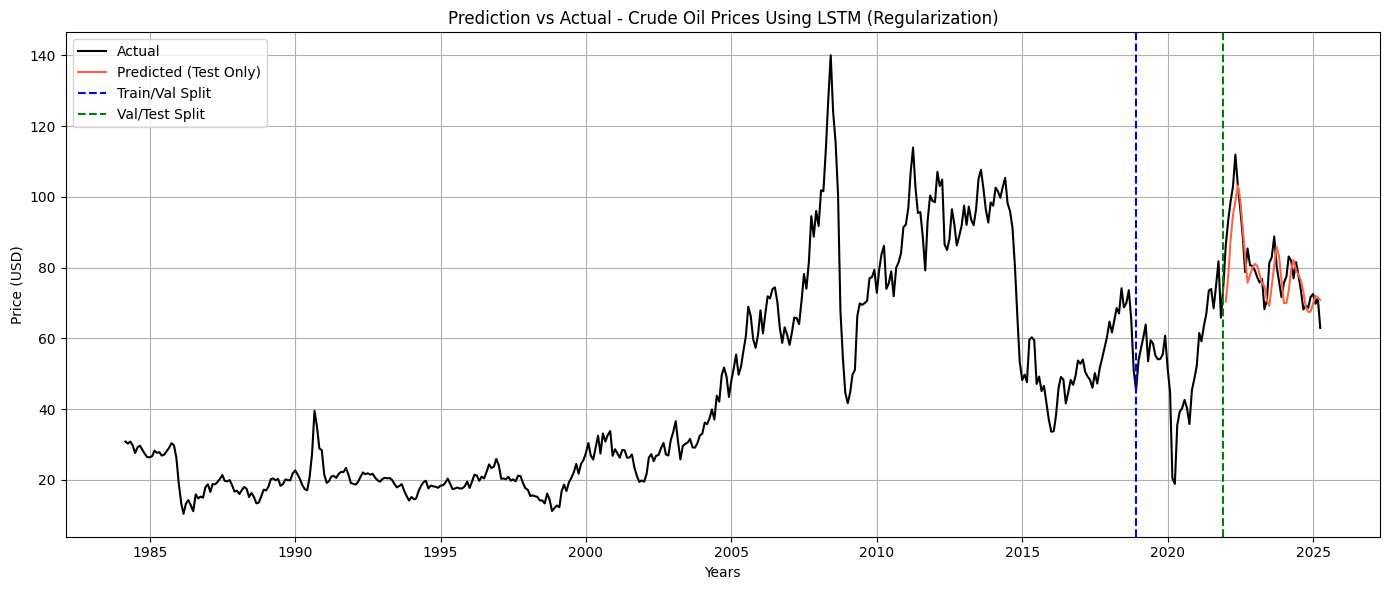

In [28]:
# Gabungkan semua tanggal dan nilai aktual
full_dates = pd.concat([dates[train_idx], dates[val_idx], dates[test_idx]])
full_actual = np.concatenate([y_train_inv.flatten(), y_val_inv.flatten(), y_test_inv.flatten()])

# Plot
plt.figure(figsize=(14,6))
plt.plot(full_dates, full_actual, label='Actual', color='black')
plt.plot(dates[test_idx], y_test_pred_inv, label='Predicted (Test Only)', color='tomato')
plt.axvline(dates[train_idx].iloc[-1], color='blue', linestyle='--', label='Train/Val Split')
plt.axvline(dates[val_idx].iloc[-1], color='green', linestyle='--', label='Val/Test Split')
plt.title("Prediction vs Actual - Crude Oil Prices Using LSTM (Regularization)")
plt.xlabel("Years")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("drive/MyDrive/Colab Notebooks/Crude Oil Price LSTM/Crude Oil Price Images/7-Prediction_vs_Actual_AllRegularization.png", dpi=300)
plt.show()
